In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import sys
sys.path.insert(0, "D:/IIT/DDP/DDP/B-SOID/")
import random
import numpy as np
import seaborn as sns

from BSOID.bsoid import *
from BSOID.preprocessing import *
from BSOID.features.displacement_feats import *

In [ ]:
raw_dir = "../../../data/videos/"
raw_files = [os.path.join(raw_dir, f) for f in os.listdir(raw_dir) if f.endswith(".h5")]

bodyparts = []

fdata = []
for f in raw_files:
    conf, pos = process_h5py_data(h5py.File(f, 'r'))
    bsoid_data = bsoid_format(conf, pos)
    data, perc_filt = likelihood_filter(bsoid_data, fps=30, bodyparts=np.arange(11))
    print(f'filtered {round(perc_filt, 2)}% of data')
    fdata.append(data)

# Embedding for Visualization

In [54]:
from numba import njit
@njit(fastmath=True)
def KL(x, y):
    n = x.shape[0]
    x_sum = 0.0
    y_sum = 0.0
    kl = 0.0
    z = 1e-11

    for i in range(n):
        x_sum += (x[i] + z)
        y_sum += (y[i] + z)

    for i in range(n):
        kl += ((x[i] + z) / x_sum) * np.log(((x[i] + z) / x_sum) / ((y[i] + z) / y_sum))

    return kl

from itertools import combinations
def comb_extractor(fdata, stride_window):
    x_raw, y_raw = fdata['x'], fdata['y']
    assert x_raw.shape == y_raw.shape
    N, d = x_raw.shape

    win_len = stride_window // 2
    
    x, y = np.zeros_like(x_raw), np.zeros_like(y_raw)
    for i in range(x.shape[1]):
        x[:,i] = smoothen_data(x_raw[:,i], win_len)
        y[:,i] = smoothen_data(y_raw[:,i], win_len)

    # all combinations of links
    links = []
    for i, j in combinations(range(d), 2):
        links.append(np.array([x[:,i] - x[:,j], y[:,i] - y[:,j]]).T)
    
    # lengths
    link_lens = np.vstack([np.linalg.norm(link, axis=1) for link in links]).T
    # angles
    link_angles = np.vstack([np.arctan2(link[:,1], link[:,0]) for i, link in enumerate(links)]).T
    
    link_lens = windowed_feats(link_lens, stride_window, mode="mean")
    link_angles = windowed_feats(link_angles, stride_window, mode="sum")
    
    return np.hstack((link_lens, link_angles))

from BSOID.features.displacement_feats import extract_feats
def extract_all_feats(fdata, fps=30, stride_window=10):
#     extract_feats_wrapper = lambda data: extract_feats(data, fps, stride_window)[stride_window:-1:stride_window]
    data = Parallel(n_jobs=6)(delayed(comb_extractor)(data, stride_window) for data in fdata)
    return np.vstack(data)

In [55]:
bsoid = BSOID("../config/config.yaml")
fdata = bsoid.load_filtered_data()
feats = extract_all_feats(fdata["C57BL/6NJ"])
del fdata

    Run ID       : dis
 Save Location   : D:/IIT/DDP/data\dis/output
      FPS        : 30
 Min. Confidence : 0.3
  Stride Window  : 333ms



In [74]:
from behavelet import wavelet_transform
_, _, wav = wavelet_transform(feats, n_freqs=25, fsample=30., fmin=1., fmax=15., n_jobs=-1)

In [5]:
strains = list(fdata.keys())

In [109]:
from sklearn.preprocessing import MinMaxScaler

def plot(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], **kwargs)
    plt.show()
    
comb_feats = np.hstack((feats, PCA(n_components=56).fit_transform(wav)))
# comb_feats = StandardScaler().fit_transform(feats)
mapper = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.0, verbose=True, metric="euclidean", densmap=True).fit(comb_feats)
embed = MinMaxScaler().fit_transform(mapper.embedding_)

UMAP(densmap=True, min_dist=0.0, n_neighbors=50, verbose=True)
Construct fuzzy simplicial set
Sat May  8 07:37:00 2021 Finding Nearest Neighbors
Sat May  8 07:37:00 2021 Building RP forest with 17 trees
Sat May  8 07:37:00 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sat May  8 07:37:13 2021 Finished Nearest Neighbor Search
Sat May  8 07:37:17 2021 Construct embedding
Sat May  8 07:37:30 2021 Computing original densities
	completed  0  /  400 epochs
	completed  40  /  400 epochs
	completed  80  /  400 epochs
	completed  120  /  400 epochs
	completed  160  /  400 epochs
	completed  200  /  400 epochs
	completed  240  /  400 epochs
	completed  280  /  400 epochs
	completed  320  /  400 epochs
	completed  360  /  400 epochs
Sat May  8 07:39:58 2021 Finished embedding


<IPython.core.display.Javascript object>


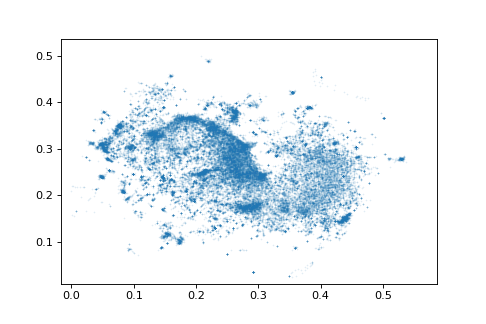

In [108]:
plot(embed, alpha=0.2, s=0.1)

In [95]:
embedding = umap.UMAP(n_components=20, n_neighbors=90, verbose=True).fit_transform(comb_feats)
labs, _, soft_labs, _ = cluster_with_hdbscan(embedding, [0.4, 1.2, 12], bsoid.hdbscan_params)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=20, n_neighbors=90,
     verbose=True)
Construct fuzzy simplicial set
Sat May  8 06:47:25 2021 Finding Nearest Neighbors
Sat May  8 06:47:25 2021 Building RP forest with 17 trees
Sat May  8 06:47:25 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Sat May  8 06:48:13 2021 Finished Nearest Neighbor Search
Sat May  8 06:48:14 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat May  8 06:49:11 2021 Finished embedding


INFO:root:identified 3 clusters (max is 3) with min_sample_prop=0.4 and entropy_ratio=0.064
INFO:root:identified 3 clusters (max is 3) with min_sample_prop=0.47 and entropy_ratio=0.064
INFO:root:identified 3 clusters (max is 3) with min_sample_prop=0.55 and entropy_ratio=0.064
INFO:root:identified 42 clusters (max is 42) with min_sample_prop=0.62 and entropy_ratio=0.954
INFO:root:identified 36 clusters (max is 42) with min_sample_prop=0.69 and entropy_ratio=0.958
INFO:root:identified 34 clusters (max is 42) with min_sample_prop=0.76 and entropy_ratio=0.942
INFO:root:identified 32 clusters (max is 42) with min_sample_prop=0.84 and entropy_ratio=0.943
INFO:root:identified 28 clusters (max is 42) with min_sample_prop=0.91 and entropy_ratio=0.945
INFO:root:identified 23 clusters (max is 42) with min_sample_prop=0.98 and entropy_ratio=0.909
INFO:root:identified 4 clusters (max is 42) with min_sample_prop=1.05 and entropy_ratio=0.332
INFO:root:identified 4 clusters (max is 42) with min_sampl

<IPython.core.display.Javascript object>


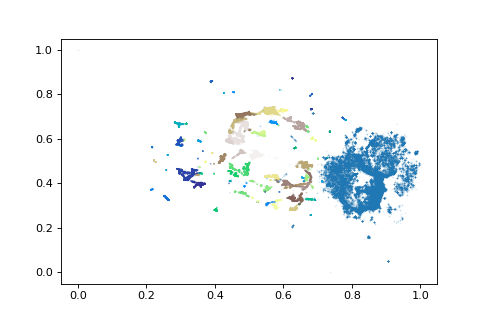

In [99]:
plot(embed[labs>=0], alpha=0.2, s=0.2, c=soft_labs[labs>=0], cmap="terrain")

In [21]:
strains

['CBA/J',
 'SEA/GnJ',
 'B6AF1/J',
 'CAST/EiJ',
 'NON/ShiLtJ',
 'CZECHII/EiJ',
 'I/LnJ',
 'C3H/HeJ',
 'C57BLKS/J',
 'MSM/MsJ',
 'MA/MyJ',
 'NZB/BlNJ',
 'B6CBAF1/J',
 'C3H/HeOuJ',
 'KK/HiJ',
 'DBA/2J',
 'BTBR T<+>ltpr3<tf>/J',
 'SWR/J',
 'CByB6F1/J',
 'SJL/J',
 'NOR/LtJ',
 '129X1/SvJ',
 'A/J',
 'B6C3F1/J',
 'SM/J',
 'MRL/MpJ',
 'C57BL/6NJ',
 'B6D2F1/J',
 'NOD/ShiLtJ',
 'NZW/LacJ',
 'NZBWF1/J',
 'C57BR/cdJ',
 'NU/J',
 'PL/J',
 'FVB/NJ',
 'DBA/1J',
 'C57BL/6J',
 'C58/J',
 'C3HeB/FeJ',
 'BALB/cJ',
 'LP/J',
 'MOLF/EiJ',
 '129S1/SvlmJ',
 'LG/J',
 'BALB/cByJ',
 'CAF1/J',
 'B6SJLF1/J',
 'CBA/CaJ',
 'RIIIS/J',
 'C57BL/10SnJ',
 '129P3/J',
 'TALLYHO/JngJ',
 'CB6F1/J',
 'PWD/PhJ',
 'B6129PF1/J',
 'C57L/J',
 'B6129SF1/J',
 'AKR/J']

In [105]:
%matplotlib notebook